In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import os
import time
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
from pathlib import Path
from tqdm import tqdm

from data_loader_pytorch import DataGenerator
from models_pytorch import VAEmodel, LSTMModel
from trainers_pytorch import VAETrainer
from utils import process_config, create_dirs

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # keep GPU ordering consistent
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
# load VAE model
config = process_config('config.json')
# create the experiments dirs
create_dirs([config['result_dir'], config['checkpoint_dir'], config['checkpoint_dir_lstm']])
# create your data generator
data = DataGenerator(config)

In [5]:
# create a VAE model and load the latest checkpoint
vae_model = VAEmodel(config).to(device)
vae_model.eval()
vae_trainer = VAETrainer(vae_model, data, config)

checkpoint_dir = config['checkpoint_dir']
checkpoint_files = [f for f in Path(checkpoint_dir).iterdir() if f.name.startswith('vae_checkpoint') and f.name.endswith('.pth')]
if not checkpoint_files:
    raise FileNotFoundError(f"No VAE checkpoint found in {checkpoint_dir}")
latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.name.split('_')[-1].split('.')[0]))
vae_trainer.load_model(latest_checkpoint)
vae_model.eval()


Model loaded from ../experiments/local-results/WESAD/batch-32/WESAD-48-12-6-fixedSigma-0.1/checkpoint/vae_checkpoint_epoch_10.pth


VAEmodel(
  (enc_conv1): Conv2d(1, 32, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
  (enc_conv2): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
  (enc_conv3): Conv2d(64, 128, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
  (enc_conv4): Conv2d(128, 512, kernel_size=(6, 14), stride=(1, 1))
  (enc_fc): Linear(in_features=512, out_features=24, bias=True)
  (enc_fc_mean): Linear(in_features=24, out_features=6, bias=True)
  (enc_fc_std): Linear(in_features=24, out_features=6, bias=True)
  (dec_fc): Linear(in_features=6, out_features=512, bias=True)
  (dec_conv1): Conv2d(512, 768, kernel_size=(1, 1), stride=(1, 1))
  (dec_conv2): Conv2d(256, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (dec_conv3): Conv2d(128, 128, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (dec_conv4): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (dec_out): Conv2d(16, 14, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
)

In [6]:
# load LSTM model
lstm_model = LSTMModel(config).to(device)
lstm_checkpoint_path = Path(config['checkpoint_dir_lstm']) / 'lstm_model.pth'
if not lstm_checkpoint_path.is_file():
    raise FileNotFoundError(f"Expected LSTM checkpoint at {lstm_checkpoint_path}")
lstm_state_dict = torch.load(lstm_checkpoint_path, map_location=device)
lstm_model.load_state_dict(lstm_state_dict)
lstm_model.eval()
print(f"Loaded LSTM checkpoint: {lstm_checkpoint_path.name}")

Loaded LSTM checkpoint: lstm_model.pth


In [38]:
# load normalised time series
data_dir = Path('../data/')

train_df = pd.read_csv(data_dir / 'train.csv')
train_df = train_df.drop(columns=['label', 'subject_id'])
train_m = train_df.mean()
train_std = train_df.std()

test_df = pd.read_csv(data_dir / 'test.csv')
test_subjects = test_df.pop('subject_id')
test_label = test_df.pop('label')
test_df_normalized = (test_df - train_m) / train_std

result = {}
result['test'] = test_df_normalized.to_numpy()
result['idx_anomaly_test'] = test_label[test_label == 1].index.to_numpy()
result['train_m'] = train_m.values[0]
result['train_std'] = train_std.values[0]
result['t_unit'] = '0.25 sec'
result['t_test'] = np.arange(len(test_df_normalized))

test_windows, test_seq = data.test_set_vae['data'], data.test_set_lstm['data']
print(test_windows.shape)
print(test_seq.shape)

(17894, 48, 14)
(16838, 12, 48, 14)


In [8]:
# Evaluate ELBO and LSTM prediction error on the validation set
# evaluate some anomaly detection metrics
def evaluate_vae_anomaly_metrics_for_a_window(test_win):
    window_tensor = torch.from_numpy(test_win).float().unsqueeze(0).to(device)
    with torch.no_grad():
        recon_win, latent_mean, latent_std = vae_model(window_tensor)
    recon_win = recon_win.squeeze(0).cpu().numpy()
    latent_mean = latent_mean.squeeze(0).cpu().numpy()
    latent_std = latent_std.squeeze(0).cpu().numpy()

    test_vae_recons_error = np.sum(np.square(recon_win - test_win))
    safe_std = np.clip(latent_std, 1e-9, None)
    test_vae_kl = 0.5 * (
        np.sum(np.square(latent_mean))
        + np.sum(np.square(safe_std))
        - np.sum(np.log(np.square(safe_std)))
        - config['code_size']
    )

    sigma2 = vae_model.get_sigma2().item()
    input_dims = vae_model.input_dims
    sigma_regularisor = input_dims / 2.0 * np.log(sigma2) + input_dims * np.pi
    test_vae_elbo = test_vae_recons_error / sigma2 + test_vae_kl + sigma_regularisor
    return test_vae_recons_error, test_vae_kl, test_vae_elbo


def evaluate_lstm_anomaly_metric_for_a_seq(test_seq):
    seq_tensor = torch.from_numpy(test_seq).float().to(device)
    seq_tensor = seq_tensor.view(config['l_seq'], config['l_win'], config['n_channel'])

    with torch.no_grad():
        vae_mean, _ = vae_model.encode(seq_tensor)
        input_embeddings = vae_mean[:-1].unsqueeze(0)
        lstm_pred = lstm_model(input_embeddings).squeeze(0)
        embedding_error = torch.sum((vae_mean[1:] - lstm_pred) ** 2).item()

        reconstructed = vae_model.decode(lstm_pred)
        reconstructed = reconstructed.squeeze(-1)
        target_windows = seq_tensor[1:].squeeze(-1)
        reconstruction_error = torch.sum((reconstructed - target_windows) ** 2).item()

    return reconstruction_error, embedding_error

n_val_vae = data.val_set_vae['data'].shape[0]
n_val_lstm = data.val_set_lstm['data'].shape[0]

val_vae_recons_error = np.zeros(n_val_vae)
val_vae_kl_error = np.zeros(n_val_vae)
val_vae_elbo_loss = np.zeros(n_val_vae)
for i in tqdm(range(n_val_vae)):
    val_vae_recons_error[i], val_vae_kl_error[i], val_vae_elbo_loss[i] = evaluate_vae_anomaly_metrics_for_a_window(data.val_set_vae['data'][i])

val_lstm_recons_error, val_lstm_embedding_error = np.zeros(n_val_lstm), np.zeros(n_val_lstm)
for i in tqdm(range(n_val_lstm)):
    val_lstm_recons_error[i], val_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(data.val_set_lstm['data'][i])


100%|██████████| 11246/11246 [00:16<00:00, 694.70it/s]


In [9]:
from scipy.stats import norm
def plot_histogram(test_anomaly_metric, n_bins, title, mean=None, std=None, xlim=None, saveplot=False):
    test_anomaly_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    his = plt.hist(test_anomaly_list, bins=n_bins, density=True)
    if mean is None and std is None:
        mean = np.mean(test_anomaly_list)
        std = np.std(test_anomaly_list)
        legend_label = None
    else:
        legend_label = 1
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
    plt.title(title)
    plt.xlabel('anomaly score value')
    plt.ylabel('probability density')
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, np.amax(test_anomaly_list))
    if legend_label is None:
        plt.legend(('Fitted Gaussian', 'histogram'))
    else:
        plt.legend(('normal data distribution','test data distribution (contain anomalies)'))
    if saveplot:
        savefig(config['result_dir']+'reconstruction_error_histogram.pdf')
    else:
        plt.show()
    threshold_25 = np.percentile(test_anomaly_list, 25)
    threshold_75 = np.percentile(test_anomaly_list, 75)
    threshold_1 = np.percentile(test_anomaly_list, 99)
    idx_large_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold_1))
#     print(his[0][-20:])
#     print(his[1][-20:])
    print("25% percentile: {}".format(threshold_25))
    print("75% percentile: {}".format(threshold_75))
#     print("Median: {}".format(np.median(test_anomaly_list)))
#     print("Mean: {}".format(np.mean(test_anomaly_list)))
#     print("Std dev: {}".format(np.std(test_anomaly_list)))
    print("These windows scored the top 1% of anomaly metric ({}): \n{}".format(threshold_1, idx_large_error))
    return mean, std

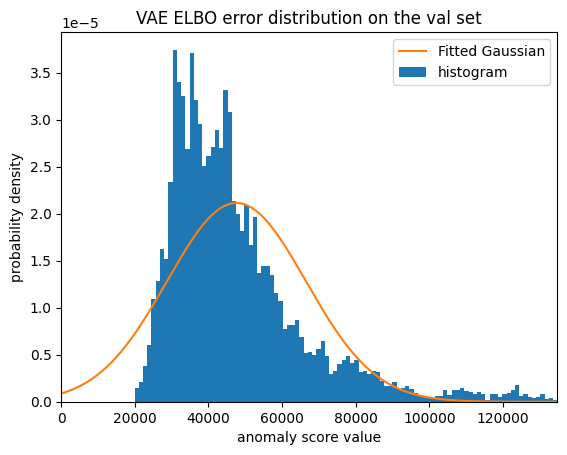

25% percentile: 34675.77949502249
75% percentile: 54613.45406899792
These windows scored the top 1% of anomaly metric (120502.08062652497): 
[3059 3060 3061 3062 3063 3064 3065 3066 3067 3068 3069 3070 3071 3072
 3073 5021 5022 5023 5024 5025 5026 5027 5028 5029 5030 5031 5032 5033
 5034 5035 6034 6035 6036 6037 6038 6039 6040 6041 6042 6043 6044 6045
 6046 6047 6048 6611 6612 6615 6616 6617 6618 6619 6620 6621 6622 6623
 6624 6625 6626 6627 6628 6629 6630 6631 6632 6633 6634 6635 6636 7526
 7527 7528 7529 7530 7531 7532 7533 7534 7535 7536 7537 7538 7539 7540
 7541 7542 7543 7544 7545 7546 7547 7548 7549 7550 7551 7552 7553 7554
 7555 7556 7557 7558 7559 7560 7561 7562 7563 7718 7719 7720 7721 7722
 7723 7724 7725 7726 7727 9979 9980 9981 9982 9983 9984 9985]


In [10]:
# Histogram of VAE ELBO loss - validation set
vae_elbo_m, vae_elbo_std = plot_histogram(val_vae_elbo_loss, 100, 
                                          'VAE ELBO error distribution on the val set', 
                                          mean=None, std=None, xlim=None)

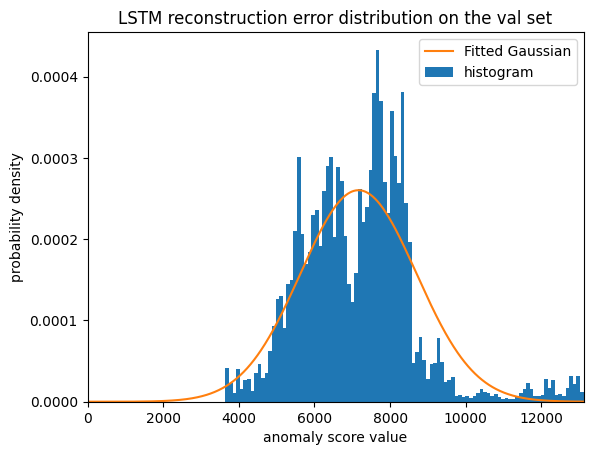

25% percentile: 6093.879638671875
75% percentile: 8030.9683837890625
These windows scored the top 1% of anomaly metric (12715.037890624999): 
[ 5683  5684  5800  5801  5917  5918  6034  6151  6268  6269  6385  6386
  6502  6619  6620  6736  6737  6853  6854  6970  6971  7087  7088  7204
  7205  7321  7322  7438  7439  7555  7556  7672  7673  7788  7789  7790
  7905  7906  7907  8022  8023  8024  8139  8140  8141  8256  8257  8258
  8373  8374  8375  8490  8491  8492  8607  8608  8609  8724  8725  8726
  8841  8842  8843  8958  8959  8960  9075  9076  9077  9192  9193  9194
  9309  9310  9311  9426  9427  9428  9543  9544  9545  9660  9661  9662
  9777  9778  9779  9894  9895  9896 10011 10012 10013 10128 10129 10130
 10245 10246 10362 10363 10479 10480 10596 10597 10713 10714 10830 10831
 10947 10948 11063 11064 11179]


In [11]:
# Histogram of LSTM reconstruction error - validation set 
#  --> to decide the anomaly detection threshold
lstm_recons_m, lstm_recons_std = plot_histogram(val_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the val set', 
                                              mean=None, std=None, xlim=None)

In [12]:
# Evaluate the anomaly metrics on the test windows and sequences
n_test_lstm = test_seq.shape[0]

test_lstm_recons_error, test_lstm_embedding_error = np.zeros(n_test_lstm), np.zeros(n_test_lstm)
for i in tqdm(range(n_test_lstm)):
    test_lstm_recons_error[i], test_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(test_seq[i])
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(test_lstm_recons_error)))

100%|██████████| 16838/16838 [00:23<00:00, 713.38it/s]

All windows' reconstruction error is computed.
The total number of windows is 16838


25% percentile: 5812.94140625
75% percentile: 10548.182861328125
These windows scored the top 1% of anomaly metric (14261.0264453125): 
[ 8374  8388  8391  8392  8393  8551  8552  8566  8569  8570  8571  8729
  8730  8747  8748  8749  8867  8907  8908  8925  8926  9045  9085  9086
  9103  9223  9263  9264  9281  9401  9441  9442  9459  9579  9619  9620
  9637  9757  9797  9798  9935  9975  9976 10113 10153 10154 10331 10332
 10509 10510 10688 10866 11044 11222 11400 11417 11578 11594 11595 11756
 11772 11773 11934 11950 11951 12128 12129 12306 12307 12484 12485 12659
 12662 12663 12664 12837 12840 12841 12842 13015 13018 13019 13020 13193
 13196 13197 13198 13371 13374 13375 13376 13549 13552 13553 13554 13727
 13730 13731 13732 13905 13908 13909 13910 14083 14086 14087 14088 14261
 14264 14265 14266 14438 14441 14442 14443 14615 14618 14619 14620 14792
 14795 14796 14797 14969 14972 14973 14974 15146 15149 15150 15151 15323
 15326 15327 15328 15500 15503 15504 15505 15677 15680 15681 

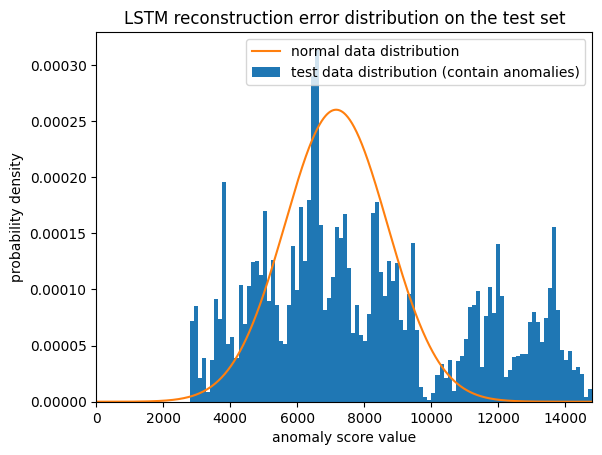

In [13]:
# Histogram of LSTM reconstruction error - test set 
#  --> to detect anomaly now
_, _ = plot_histogram(test_lstm_recons_error, 100,
                      'LSTM reconstruction error distribution on the test set', 
                      mean=lstm_recons_m, std=lstm_recons_std, xlim=None, saveplot=True)

In [14]:
# Produce the ground truth anomaly indices 
# if result['idx_split'][0] == 0:
#     idx_anomaly_test = result['idx_anomaly_test']
# else:
#     idx_anomaly_test = result['idx_anomaly_test'][0]
idx_anomaly_test = result['idx_anomaly_test']
anomaly_index_lstm = []
test_labels_lstm = np.zeros(n_test_lstm)
for i in tqdm(range(len(idx_anomaly_test))):
    idx_start = idx_anomaly_test[i]-(config['l_win']*config['l_seq']-1)
    idx_end = idx_anomaly_test[i]+1
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_test_lstm:
        idx_end = n_test_lstm
    anomaly_index_lstm.append(np.arange(idx_start,idx_end))
    test_labels_lstm[idx_start:idx_end] = 1
    
print(test_labels_lstm.shape)

100%|██████████| 5584/5584 [00:00<00:00, 280840.73it/s]

(16838,)


In [15]:
def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    idx_error = np.flatnonzero(test_anomaly_metric > threshold)
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
    return idx_error

In [16]:
def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    idx_detected_anomaly_set = set(idx_detected_anomaly)
    idx_detected_anomaly_extended = set(idx_detected_anomaly)
    
    # anomaly_index는 이상 구간(리스트의 리스트)이라고 가정
    for anomaly_win in anomaly_index:
        # 현재 이상 구간(anomaly_win)이 기존 탐지에 포함되었는지 확인
        # set intersection이 빠름
        if idx_detected_anomaly_set.intersection(anomaly_win):
            # 포함되었다면 해당 구간 전체를 확장된 set에 추가
            idx_detected_anomaly_extended.update(anomaly_win)

    # numpy로 변환 후 정렬
    return np.sort(np.array(list(idx_detected_anomaly_extended), dtype=int))

In [17]:
def count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels):  
    detected_labels = test_labels[idx_detected_anomaly]
    n_TP = np.sum(detected_labels == 1)
    n_FP = np.sum(detected_labels == 0)
    n_FN = np.sum(test_labels == 1) - n_TP
    
    return n_TP, n_FP, n_FN

In [18]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, test_labels):
    n_TP, n_FP, n_FN = count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels)
    
    precision = n_TP / (n_TP + n_FP) if (n_TP + n_FP) > 0 else 1.0
    recall = n_TP / (n_TP + n_FN) if (n_TP + n_FN) > 0 else 0.0
    F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, F1, n_TP, n_FP, n_FN

In [19]:
n_threshold = 200
precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)
precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)
i = 0
threshold_list = np.linspace(np.amin(test_lstm_recons_error), np.amax(test_lstm_recons_error), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)
for threshold in tqdm(threshold_list):
    #print(threshold_list[i])
    idx_detection_lstm = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
    precision[i], recall[i], F1[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm, 
                                                                           anomaly_index_lstm, 
                                                                           test_labels_lstm)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    # introduced in "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications"
    idx_detection_lstm_augmented = augment_detected_idx(idx_detection_lstm, anomaly_index_lstm)
    precision_aug[i], recall_aug[i], F1_aug[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm_augmented, 
                                                                                       anomaly_index_lstm, 
                                                                                       test_labels_lstm)
    i = i + 1

100%|██████████| 200/200 [00:32<00:00,  6.16it/s]


In [20]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug[1:] * (recall_aug[1:] - recall_aug[:-1]))
print("Average precision is {}".format(average_precision_aug))

Best F1 score is 0.4984807864164432
Best threshold is 2867.4893461447864
At this threshold, precision is 0.33210288163848534, recall is 0.9989255014326648
Average precision is 0.29875350733889927

Augmented detection:
Best F1 score is 0.7707916350334737
Best threshold is 9563.97522524733
At this threshold, precision is 0.6270634475014037, recall is 1.0
Average precision is 0.7805582677873273


In [21]:
# Now select a threshold
threshold = 9563

print("Threshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

Threshold is 9563

PR evaluation using augmented detection:
Precision: 0.6270634475014037
Recall: 1.0
F1: 0.7707916350334737
TP: 5584
FP: 3321
FN: 0


In [22]:
def slice_detected_indices_into_seq(idx_detection, interval):
    detected_seq = []
    i = 0
    while i < len(idx_detection):
        if i == 0:
            cur_seq = [idx_detection[i]]
            i = i + 1
        else:
            if idx_detection[i] - idx_detection[i-1] > interval:
                detected_seq.append(cur_seq)
                cur_seq = [idx_detection[i]]
            else:
                cur_seq.append(idx_detection[i])
                if i == len(idx_detection) - 1:
                    detected_seq.append(cur_seq)
            i = i + 1
    
    print("Detected {} sequences".format(len(detected_seq)))
    return detected_seq

In [ ]:
def plot_detected_anomalies(idx_detection, interval, result, detection_method, augmented_flag=1, y_scale=5, y_lim=None):
    detected_seq = slice_detected_indices_into_seq(idx_detection, interval=interval)
    t_test = result['t_test']
    test = result['test']
    idx_anomaly_test = result['idx_anomaly_test']
        
    # plot detected sequences
    fig, axs = plt.subplots(1, 1, figsize=(18, 5), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t_test, test[:, 0]) # plot only the first channel
    for j in range(len(idx_anomaly_test)):
        if j == 0:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(0.8 * y_scale, y_scale, 20), 'r-', label='true anomalies')
        else:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(0.8 * y_scale, y_scale, 20), 'r-')
        
    for i in range(len(detected_seq)):
        for j in detected_seq[i]:
            if j == detected_seq[0][0]:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-', label='detected anomalies')
            else:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-')
    
    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(0.8 * y_scale, y_scale, 20), 'r--')

    for i in range(len(detected_seq)):
        interval_x = np.asarray([detected_seq[i][0], detected_seq[i][-1]+interval*2])
        interval_y = np.asarray([y_scale,y_scale])
        if i == 0:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y', label='detected anomaly windows')
        else:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
        interval_y = np.asarray([-y_scale,-y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
    axs.grid(True)
    axs.set_xlim(0, len(t_test))
    if y_lim is None:
        axs.set_ylim(-y_scale, y_scale)
    else:
        axs.set_ylim(-y_scale, y_lim)
    axs.set_xlabel("timestamp (every {})".format(result['t_unit']))
    axs.set_ylabel("normalised readings")
    axs.set_title(f"dataset test sequence\n(normalised by train mean {result['train_m']:.4f} and std {result['train_std']:.4f})\n Detection method: {detection_method}")
    axs.legend()
    savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))

Detected 3 sequences


/tmp/ipykernel_42109/827925385.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))
/tmp/ipykernel_42109/827925385.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))
/home/peunsu/ml_project/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


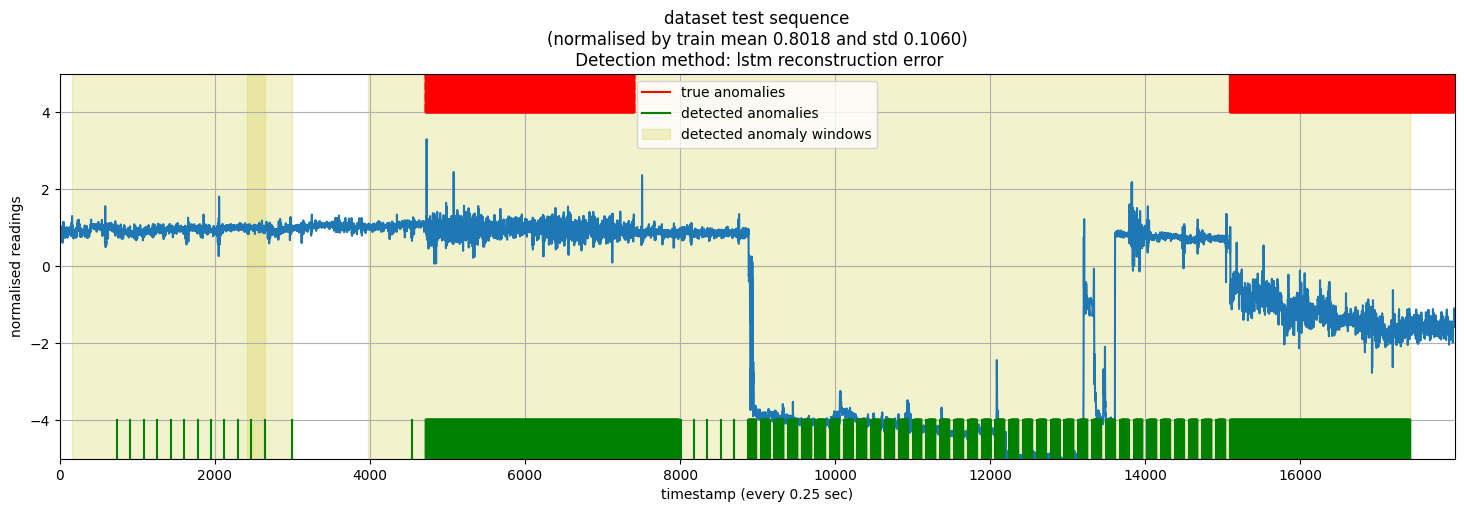

In [50]:
plot_detected_anomalies(idx_detection_augmented, 
                        interval=config['l_win']*config['l_seq']/2,
                        result=result, 
                        detection_method='lstm reconstruction error',
                        augmented_flag=1,
                        y_scale=5,
                        y_lim=5)